# Optional Lab: Back propagation using a computation graph
Working through this lab will give you insight into a key algorithm used by most machine learning frameworks. Gradient descent requires the derivative of the cost with respect to each parameter in the network.  Neural networks can have millions or even billions of parameters. The *back propagation* algorithm is used to compute those derivatives. *Computation graphs* are used to simplify the operation. Let's dig into this below.

In [1]:
%run -i notebooks/advanced-learning-algorithms/utils/autils.py
%run -i notebooks/advanced-learning-algorithms/utils/lab_utils_common.py
%run -i notebooks/advanced-learning-algorithms/utils/lab_utils_multiclass_TF.py
%run -i notebooks/advanced-learning-algorithms/utils/lab_utils_multiclass.py
%run -i notebooks/advanced-learning-algorithms/utils/lab_utils_relu.py
%run -i notebooks/advanced-learning-algorithms/utils/lab_utils_softmax.py
%run -i notebooks/advanced-learning-algorithms/utils/lab_utils_backprop

2024-01-01 22:10:26.104895: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 22:10:26.106355: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 22:10:26.125559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 22:10:26.125601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 22:10:26.126325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
from sympy import *
import numpy as np
import re
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox
from matplotlib.widgets import Button
import ipywidgets as widgets
#from lab_utils_backprop import *

## Computation Graph
A computation graph simplifies the computation of complex derivatives by breaking them into smaller steps. Let's see how this works.

Let's calculate the derivative of this slightly complex expression, $J = (2+3w)^2$. We would like to find the derivative of $J$ with respect to $w$ or $\frac{\partial J}{\partial w}$.

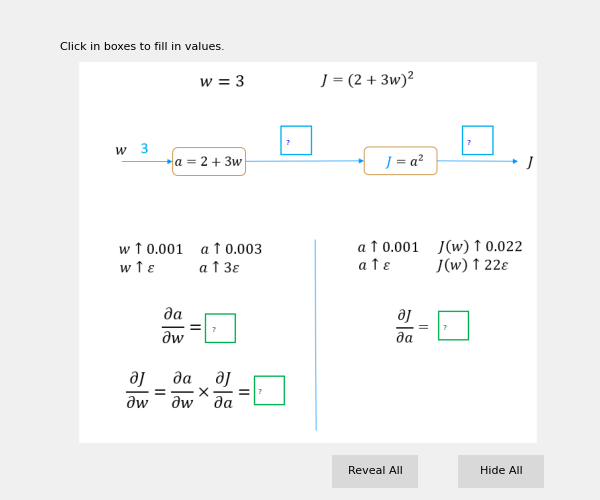

In [3]:
plt.close("all")
plt_network(config_nw0, "./notebooks/advanced-learning-algorithms/images/30.png")

Above, you can see we broke the expression into two nodes which we can work on independently. If you already have a good understanding of the process from the lecture, you can go ahead and fill in the boxes in the diagram above. You will want to first fill in the blue boxes going left to right and then fill in the green boxes starting on the right and moving to the left.
If you have the correct values, the values will show as green or blue. If the value is incorrect, it will be red. Note, the interactive graphic is not particularly robust. If you run into trouble with the interface, run the cell above again to restart.

If you are unsure of the process, we will work this example step by step below.

### Forward Propagation   
Let's calculate the values in the forward direction.

>Just a note about this section. It uses global variables and reuses them as the calculation progresses. If you run cells out of order, you may get funny results. If you do, go back to this point and run them in order.

In [4]:
w = 3
a = 2+3*w
J = a**2
print(f"a = {a}, J = {J}")

a = 11, J = 121


You can fill these values in the blue boxes above.

### Backprop

Backprop is the algorithm we use to calculate derivatives. As described in the lectures, backprop starts at the right and moves to the left. The first node to consider is $J = a^2$ and the first step is to find $\frac{\partial J}{\partial a}$


### $\frac{\partial J}{\partial a}$ 
#### Arithmetically
Find $\frac{\partial J}{\partial a}$ by finding how $J$ changes as a result of a little change in $a$. This is described in detail in the derivatives optional lab.

In [5]:
a_epsilon = a + 0.001       # a epsilon
J_epsilon = a_epsilon**2    # J_epsilon
k = (J_epsilon - J)/0.001   # difference divided by epsilon
print(f"J = {J}, J_epsilon = {J_epsilon}, dJ_da ~= k = {k} ")

J = 121, J_epsilon = 121.02200099999999, dJ_da ~= k = 22.000999999988835 


$\frac{\partial J}{\partial a}$ is 22 which is $2\times a$. Our result is not exactly $2 \times a$ because our epsilon value is not infinitesimally small. 
#### Symbolically
Now, let's use SymPy to calculate derivatives symbolically as we did in the derivatives optional lab. We will prefix the name of the variable with an 's' to indicate this is a *symbolic* variable.

In [6]:
sw,sJ,sa = symbols('w,J,a')
sJ = sa**2
sJ

a**2

In [7]:
sJ.subs([(sa,a)])

121

In [8]:
dJ_da = diff(sJ, sa)
dJ_da

2*a

So, $\frac{\partial J}{\partial a} = 2a$. When $a=11$, $\frac{\partial J}{\partial a} = 22$. This matches our arithmetic calculation above.
If you have not already done so, you can go back to the diagram above and fill in the value for $\frac{\partial J}{\partial a}$.

### $\frac{\partial J}{\partial w}$ 

Moving from right to left, the next value we would like to compute is $\frac{\partial J}{\partial w}$. To do this, we first need to calculate $\frac{\partial a}{\partial w}$ which describes how the output of this node, $a$, changes when the input $w$ changes a little bit.

#### Arithmetically
Find $\frac{\partial a}{\partial w}$ by finding how $a$ changes as a result of a little change in $w$.

In [9]:
w_epsilon = w + 0.001       # a  plus a small value, epsilon
a_epsilon = 2 + 3*w_epsilon
k = (a_epsilon - a)/0.001   # difference divided by epsilon
print(f"a = {a}, a_epsilon = {a_epsilon}, da_dw ~= k = {k} ")

a = 11, a_epsilon = 11.003, da_dw ~= k = 3.0000000000001137 


Calculated arithmetically,  $\frac{\partial a}{\partial w} \approx 3$. Let's try it with SymPy.

In [10]:
sa = 2 + 3*sw
sa

3*w + 2

In [11]:
da_dw = diff(sa,sw)
da_dw

3

>The next step is the interesting part:
> - We know that a small change in $w$ will cause $a$ to change by 3 times that amount.
> - We know that a small change in $a$ will cause $J$ to change by $2\times a$ times that amount. (a=11 in this example)    
 so, putting these together, 
> - We  know that a small change in $w$ will cause $J$ to change by $3 \times 2\times a$ times that amount.
> 
> These cascading changes go by the name of *the chain rule*.  It can be written like this: 
 $$\frac{\partial J}{\partial w} = \frac{\partial a}{\partial w} \frac{\partial J}{\partial a} $$
 
It's worth spending some time thinking this through if it is not clear. This is a key take-away.
 
 Let's try calculating it:
 

In [12]:
dJ_dw = da_dw * dJ_da
dJ_dw

6*a

And $a$ is 11 in this example so $\frac{\partial J}{\partial w} = 66$. We can check this arithmetically:

In [ ]:
w_epsilon = w + 0.001
a_epsilon = 2 + 3*w_epsilon
J_epsilon = a_epsilon**2
k = (J_epsilon - J)/0.001   # difference divided by epsilon
print(f"J = {J}, J_epsilon = {J_epsilon}, dJ_dw ~= k = {k} ")

OK! You can now fill the values for  $\frac{\partial a}{\partial w}$ and $\frac{\partial J}{\partial w}$ in  the diagram if you have not already done so. 

**Another view**  
One could visualize these cascading changes this way:  

![](./images/31.png)

A small change in $w$ is multiplied by $\frac{\partial a}{\partial w}$ resulting in a change that is 3 times as large. This larger change is then multiplied by $\frac{\partial J}{\partial a}$ resulting in a change that is now $3 \times 22 = 66$ times larger.

## Computation Graph of a Simple Neural Network
Below is a graph of the neural network used in the lecture with different values. Try and fill in the values in the boxes. Note, the interactive graphic is not particularly robust. If you run into trouble with the interface, run the cell below again to restart.

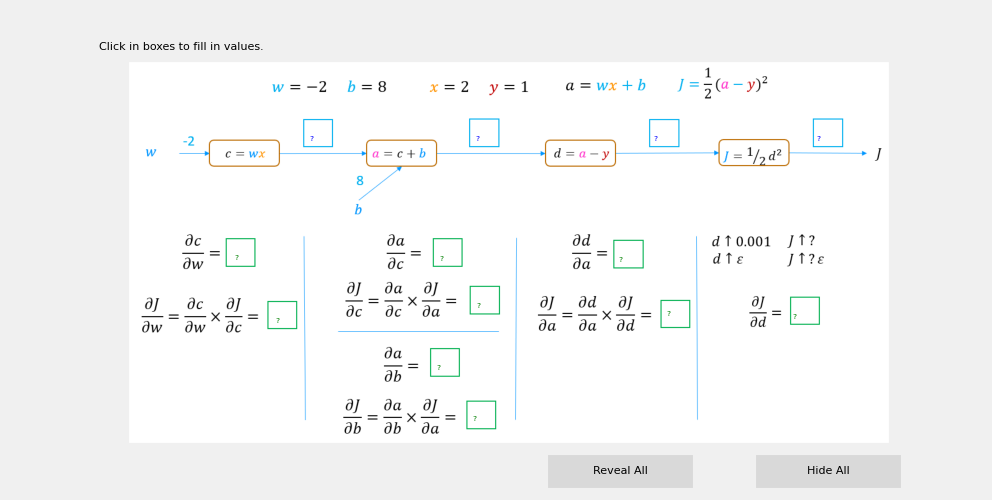

In [13]:
plt.close("all")
plt_network(config_nw1, "./notebooks/advanced-learning-algorithms/images/32.png")

Below, we will go through the computations required to fill in the above computation graph in detail. We start with the forward path.

### Forward propagation
The calculations in the forward path are the ones you have recently learned for neural networks. You can compare the values below to those you calculated for the diagram above.

In [14]:
# Inputs and parameters
x = 2
w = -2
b = 8
y = 1
# calculate per step values   
c = w * x
a = c + b
d = a - y
J = d**2/2
print(f"J={J}, d={d}, a={a}, c={c}")

J=4.5, d=3, a=4, c=-4


### Backward propagation (Backprop)


As described in the lectures, backprop starts at the right and moves to the left. The first node to consider is $J = \frac{1}{2}d^2 $ and the first step is to find $\frac{\partial J}{\partial d}$ 


### $\frac{\partial J}{\partial d}$ 

#### Arithmetically
Find $\frac{\partial J}{\partial d}$ by finding how $J$ changes as a result of a little change in $d$.

In [15]:
d_epsilon = d + 0.001
J_epsilon = d_epsilon**2/2
k = (J_epsilon - J)/0.001   # difference divided by epsilon
print(f"J = {J}, J_epsilon = {J_epsilon}, dJ_dd ~= k = {k} ")

J = 4.5, J_epsilon = 4.5030005, dJ_dd ~= k = 3.0004999999997395 


$\frac{\partial J}{\partial d}$ is 3, which is the value of $d$. Our result is not exactly $d$ because our epsilon value is not infinitesimally small. 
#### Symbolically
Now, let's use SymPy to calculate derivatives symbolically, as we did in the derivatives optional lab. We will prefix the name of the variable with an 's' to indicate this is a *symbolic* variable.

In [16]:
sx,sw,sb,sy,sJ = symbols('x,w,b,y,J')
sa, sc, sd = symbols('a,c,d')
sJ = sd**2/2
sJ

d**2/2

In [17]:
sJ.subs([(sd,d)])

9/2

In [18]:
dJ_dd = diff(sJ, sd)
dJ_dd

d

So, $\frac{\partial J}{\partial d}$ = d. When $d=3$, $\frac{\partial J}{\partial d}$ = 3. This matches our arithmetic calculation above.
If you have not already done so, you can go back to the diagram above and fill in the value for $\frac{\partial J}{\partial d}$.

### $\frac{\partial J}{\partial a}$ 


Moving from right to left, the next value we would like to compute is $\frac{\partial J}{\partial a}$. To do this, we first need to calculate $\frac{\partial d}{\partial a}$ which describes how the output of this node changes when the input $a$ changes a little bit. (Note, we are not interested in how the output changes when $y$ changes since $y$ is not a parameter.)

#### Arithmetically
Find $\frac{\partial d}{\partial a}$ by finding how $d$ changes as a result of a little change in $a$.

In [19]:
a_epsilon = a + 0.001         # a  plus a small value
d_epsilon = a_epsilon - y
k = (d_epsilon - d)/0.001   # difference divided by epsilon
print(f"d = {d}, d_epsilon = {d_epsilon}, dd_da ~= k = {k} ")

d = 3, d_epsilon = 3.0010000000000003, dd_da ~= k = 1.000000000000334 


Calculated arithmetically,  $\frac{\partial d}{\partial a} \approx 1$. Let's try it with SymPy.
#### Symbolically

In [20]:
sd = sa - sy
sd

a - y

In [21]:
dd_da = diff(sd,sa)
dd_da

1

Calculated arithmetically,  $\frac{\partial d}{\partial a}$ also equals 1.  
>The next step is the interesting part, repeated again in this example:
> - We know that a small change in $a$ will cause $d$ to change by 1 times that amount.
> - We know that a small change in $d$ will cause $J$ to change by $d$ times that amount. (d=3 in this example)    
 so, putting these together, 
> - We  know that a small change in $a$ will cause $J$ to change by $1\times d$ times that amount.
> 
>This is again *the chain rule*.  It can be written like this: 
 $$\frac{\partial J}{\partial a} = \frac{\partial d}{\partial a} \frac{\partial J}{\partial d} $$
 
 Let's try calculating it:
 

In [22]:
dJ_da = dd_da * dJ_dd
dJ_da

d

And $d$ is 3 in this example so $\frac{\partial J}{\partial a} = 3$. We can check this arithmetically:

In [23]:
a_epsilon = a + 0.001
d_epsilon = a_epsilon - y
J_epsilon = d_epsilon**2/2
k = (J_epsilon - J)/0.001   
print(f"J = {J}, J_epsilon = {J_epsilon}, dJ_da ~= k = {k} ")

J = 4.5, J_epsilon = 4.503000500000001, dJ_da ~= k = 3.0005000000006277 


OK, they match! You can now fill the values for  $\frac{\partial d}{\partial a}$ and $\frac{\partial J}{\partial a}$ in the diagram if you have not already done so. 

> **The steps in backprop**   
>Now that you have worked through several nodes, we can write down the basic method:\
> working right to left, for each node:
>- calculate the local derivative(s) of the node
>- using the chain rule, combine with the derivative of the cost with respect to the node to the right.   

The 'local derivative(s)' are the derivative(s) of the output of the current node with respect to all inputs or parameters.

Let's continue the job. We'll be a bit less verbose now that you are familiar with the method.

### $\frac{\partial J}{\partial c}$,  $\frac{\partial J}{\partial b}$

The next node has two derivatives of interest. We need to calculate  $\frac{\partial J}{\partial c}$ so we can propagate to the left. We also want to calculate   $\frac{\partial J}{\partial b}$. Finding the derivative of the cost with respect to the parameters $w$ and $b$ is the object of backprop. We will find the local derivatives,  $\frac{\partial a}{\partial c}$ and  $\frac{\partial a}{\partial b}$ first and then combine those with the derivative coming from the right, $\frac{\partial J}{\partial a}$.

In [24]:
# calculate the local derivatives da_dc, da_db
sa = sc + sb
sa

b + c

In [25]:
da_dc = diff(sa,sc)
da_db = diff(sa,sb)
print(da_dc, da_db)

1 1


In [26]:
dJ_dc = da_dc * dJ_da
dJ_db = da_db * dJ_da
print(f"dJ_dc = {dJ_dc},  dJ_db = {dJ_db}")

dJ_dc = d,  dJ_db = d


And in our example, d = 3

###  $\frac{\partial J}{\partial w}$

The last node in this example calculates `c`. Here, we are interested in how J changes with respect to the parameter w. We will not back propagate to the input $x$, so we are not interested in $\frac{\partial J}{\partial x}$. Let's start by calculating $\frac{\partial c}{\partial w}$.

In [27]:
# calculate the local derivative
sc = sw * sx
sc

w*x

In [28]:
dc_dw = diff(sc,sw)
dc_dw

x

This derivative is a bit more exciting than the last one. This will vary depending on the value of $x$. This is 2 in our example.

Combine this with $\frac{\partial J}{\partial c}$ to find $\frac{\partial J}{\partial w}$.

In [29]:
dJ_dw = dc_dw * dJ_dc
dJ_dw

d*x

In [30]:
print(f"dJ_dw = {dJ_dw.subs([(sd,d),(sx,x)])}")

dJ_dw = 2*d


$d=3$,  so $\frac{\partial J}{\partial w} = 6$ for our example.   
Let's test this arithmetically:

In [31]:
J_epsilon = ((w+0.001)*x+b - y)**2/2
k = (J_epsilon - J)/0.001  
print(f"J = {J}, J_epsilon = {J_epsilon}, dJ_dw ~= k = {k} ")

J = 4.5, J_epsilon = 4.506002, dJ_dw ~= k = 6.001999999999619 


They match! Great. You can add $\frac{\partial J}{\partial w}$ to the diagram above and our analysis is complete.

## Congratulations!
You've worked through an example of back propagation using a computation graph. You can apply this to larger examples by following the same node by node approach. 